# Data extraction and transformation for the Florianopolis, State in Brazil

This notebook is part of the project "New Schools Location in Brazil" and it is focused on the data extraction and transformation for Florianopolis  in Brazil.

## Step 0. Import libraries and setup environment

In [5]:
# Ignore warnings
import warnings

warnings.filterwarnings("ignore")

In [6]:
import os
import geopandas as gpd
import geobr
import pandas as pd
import contextily as cx
import matplotlib.pyplot as plt
import urbanpy as up
import osmnx as ox
import numpy as np
from tqdm.auto import tqdm
from shapely.geometry.point import Point
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MultiLabelBinarizer

In [7]:
tqdm.pandas()

In [8]:
# Set parameters for basemaps
from secret import *

BASEMAP = cx.providers.MapBox(
    id="mapbox/satellite-v9",
    accessToken=MAPBOX_API_KEY,
)

BASEMAP_WITH_LABELS = cx.providers.MapBox(
    id="mapbox/satellite-streets-v12",
    accessToken=MAPBOX_API_KEY,
)

BASEMAP_WHITE = cx.providers.MapBox(
    id="mapbox/light-v10",
    accessToken=MAPBOX_API_KEY,
)

BASEMAP_DARK = cx.providers.MapBox(
    id="mapbox/dark-v10",
    accessToken=MAPBOX_API_KEY,
)

In [9]:
city = "flor"

## Step 1. Define Area of Interest (AoI)

For this, we will:

* Download a administrative limits for Brazil, and get the multi-level admistrative limits of Florianopolis usig the geoBR library.
* Read schools data downloaded using the R package CensoBr.

In [10]:
if os.path.exists("outputs/brazil_state.geojson"):
    brazil = gpd.read_file("outputs/brazil_state.geojson")
else:
    brazil = geobr.read_country(year=2020, simplified=True, verbose=True)
    brazil.to_file("outputs/brazil_state.geojson", driver="GeoJSON")

In [11]:
brazil.head()

code_state abbrev_state name_state  code_region name_region  \
0        11.0           RO   Rondônia          1.0       Norte   
1        12.0           AC       Acre          1.0       Norte   
2        13.0           AM   Amazônas          1.0       Norte   
3        14.0           RR    Roraima          1.0       Norte   
4        15.0           PA       Pará          1.0       Norte   

                                            geometry  
0  MULTIPOLYGON (((-65.38150 -10.42907, -65.37916...  
1  MULTIPOLYGON (((-71.07772 -9.82774, -71.08554 ...  
2  MULTIPOLYGON (((-69.83766 -3.68659, -69.71230 ...  
3  MULTIPOLYGON (((-63.96008 2.47313, -63.96041 2...  
4  MULTIPOLYGON (((-51.43248 -0.47334, -51.42843 ...

In [12]:
# Area of Interest (AoI)
sc_state = brazil.query("abbrev_state == 'SC'")

In [13]:
# Set parameters for scalebar
point1 = sc_state.centroid.iloc[0]  # Para's center
point2 = Point(point1.x + 1, point1.y)  # One full degree of longitude (X) apart
points = gpd.GeoDataFrame(geometry=[point1, point2], crs=sc_state.crs)
points_utm = ox.project_gdf(points)  # Projected - meters
dist_meters = points.geometry.iloc[0].distance(
    points.geometry.iloc[1]
)  # Distance - meters

Let's visualize the Santa Catarina State location in Brazil

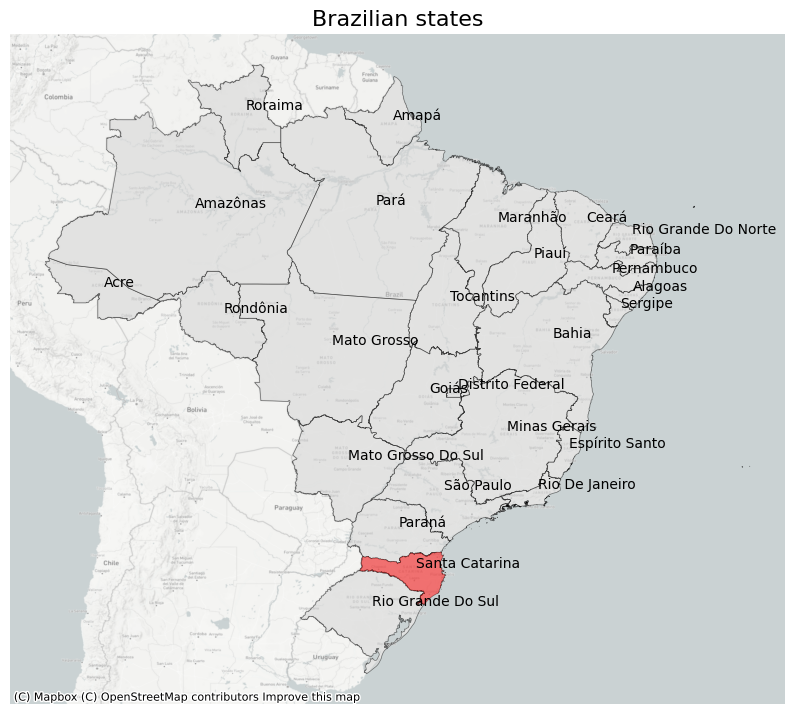

In [14]:
ax = brazil.plot(
    figsize=(10, 10), facecolor="lightgrey", edgecolor="black", linewidth=0.5, alpha=0.5
)
sc_state.plot(ax=ax, color="red", alpha=0.5)

# Add name_state labels to the map
for x, y, label in zip(
    brazil.geometry.centroid.x, brazil.geometry.centroid.y, brazil["name_state"]
):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")

# Add basemap
cx.add_basemap(ax, crs=brazil.crs.to_string(), source=BASEMAP_WHITE)

# Add scale bar
# ax.add_artist(ScaleBar(dist_meters))

ax.set_title("Brazilian states", fontsize=16)

# Remove axis
ax.set_axis_off()

# Save figure
plt.savefig(
    f"outputs/maps/{city}/01-brazil_states_{city}_red.png", dpi=300, bbox_inches="tight"
)

plt.show()

In [15]:
code_state = "SC"

In [16]:
if os.path.exists(f"outputs/{city}_intermediate_regions.geojson"):
    sc_intermediate_regions = gpd.read_file(
        f"outputs/{city}_intermediate_regions.geojson"
    )
else:
    sc_intermediate_regions = geobr.read_intermediate_region(
        code_intermadiate=code_state, year=2020
    )
    sc_intermediate_regions.to_file(
        f"outputs/{city}_intermediate_regions.geojson", driver="GeoJSON"
    )

In [17]:
if os.path.exists(f"outputs/{city}_meso_regions.geojson"):
    sc_meso_regions = gpd.read_file(f"outputs/{city}_meso_regions.geojson")
else:
    sc_meso_regions = geobr.read_meso_region(code_meso=code_state, year=2020)
    sc_meso_regions.to_file(f"outputs/{city}_meso_regions.geojson", driver="GeoJSON")

In [18]:
if os.path.exists(f"outputs/{city}_micro_regions.geojson"):
    sc_micro_regions = gpd.read_file(f"outputs/{city}_micro_regions.geojson")
else:
    sc_micro_regions = geobr.read_micro_region(code_micro=code_state, year=2020)
    sc_micro_regions.to_file(f"outputs/{city}_micro_regions.geojson", driver="GeoJSON")

In [19]:
if os.path.exists(f"outputs/{city}_muni.geojson"):
    sc_muni = gpd.read_file(f"outputs/{city}_muni.geojson")
else:
    sc_muni = geobr.read_municipality(code_muni=code_state, year=2020)
    sc_muni.to_file(f"outputs/{city}_muni.geojson", driver="GeoJSON")

Let's see the number of units and visualize each administrative level

In [20]:
pd.DataFrame(
    index=["Intermediate regions", "Meso regions", "Micro regions", "Municipalities"],
    data=[
        len(sc_meso_regions),
        len(sc_intermediate_regions),
        len(sc_micro_regions),
        len(sc_muni),
    ],
    columns=["Number of units"],
)

Number of units
Intermediate regions                6
Meso regions                        7
Micro regions                      20
Municipalities                    295

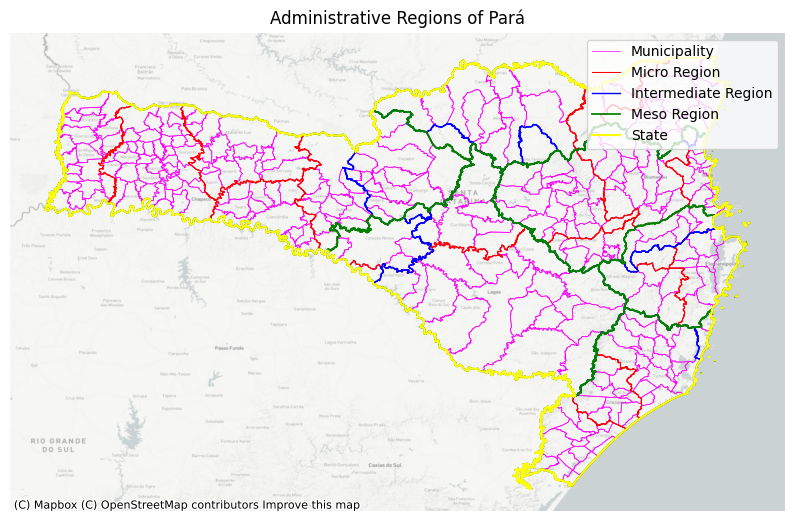

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))

legend_labels = [
    "Municipality",
    "Micro Region",
    "Intermediate Region",
    "Meso Region",
    "State",
]
colors = ["magenta", "red", "blue", "green", "yellow"]
linewidths = [0.5, 0.75, 1, 1.25, 1.5]
admin_regions = [
    sc_muni,
    sc_micro_regions,
    sc_intermediate_regions,
    sc_meso_regions,
    sc_state,
]

legend_handles = []
for i, region in enumerate(admin_regions):
    region.plot(ax=ax, facecolor="none", edgecolor=colors[i], linewidth=linewidths[i])
    # Create line2D objects with labels
    legend_handles.append(
        plt.Line2D([0], [0], color=colors[i], linewidth=linewidths[i], linestyle="-")
    )

# Set title and legend
ax.set_title("Administrative Regions of Pará")
ax.legend(legend_handles, legend_labels, loc="upper right")

# Add basemap
cx.add_basemap(ax, crs=sc_state.crs.to_string(), source=BASEMAP_WHITE)

# Add scale bar
# ax.add_artist(ScaleBar(dist_meters))

# Remove axis
ax.set_axis_off()

plt.savefig(
    f"outputs/maps/{city}/02-{city}_adm_regions.png", dpi=300, bbox_inches="tight"
)

plt.show()

In [22]:
flor_muni = sc_muni.query("name_muni == 'Florianópolis'")

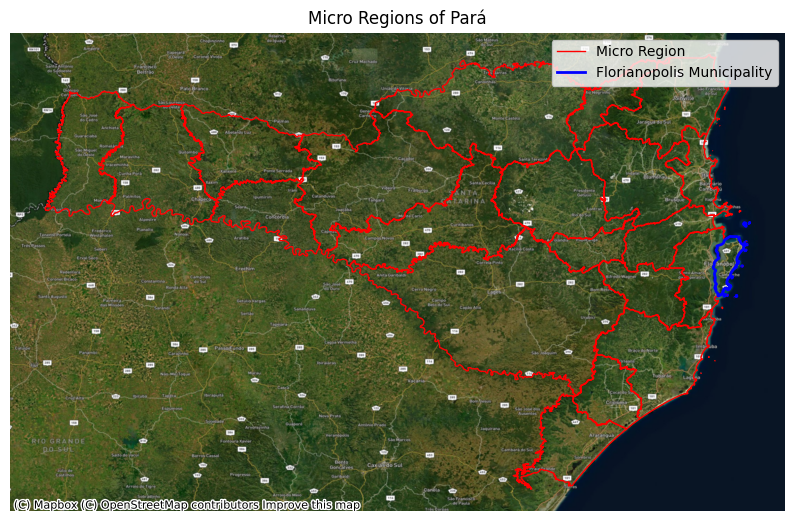

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))

legend_labels = ["Micro Region", "Florianopolis Municipality"]
colors = ["red", "blue"]
linewidths = [1, 2]
admin_regions = [sc_micro_regions, flor_muni]

legend_handles = []
for i, region in enumerate(admin_regions):
    region.plot(ax=ax, facecolor="none", edgecolor=colors[i], linewidth=linewidths[i])
    # Create line2D objects with labels
    legend_handles.append(
        plt.Line2D([0], [0], color=colors[i], linewidth=linewidths[i], linestyle="-")
    )

# Set title and legend
ax.set_title("Micro Regions of Pará")
ax.legend(legend_handles, legend_labels, loc="upper right")

# Add basemap
cx.add_basemap(ax, crs=sc_state.crs.to_string(), source=BASEMAP_WITH_LABELS)

# Add scale bar
# ax.add_artist(ScaleBar(dist_meters))

# Remove axis
ax.set_axis_off()

plt.savefig(
    f"outputs/maps/{city}/03-{city}_micro_regions.png", dpi=300, bbox_inches="tight"
)

plt.show()

Since Florianpolis is a municipality its size is perfect to work directly with UrbanPy.

> Para we are doing the analysis at the Micro regions level, it could be interesting to analyze the Micro region that contains Florianopolis.

## Step 2. Extract and process Census Sociodemographic geographical data

### Step 2.1. Extracting Census Tracts Data from IBGE

Census Tract's Geometries are obtained in this notebook with the `GeoBR` Python library

In [24]:
if os.path.exists(f"outputs/{city}_census_tracts.geojson"):
    sc_cntr = gpd.read_file(f"outputs/{city}_census_tracts.geojson")
else:
    sc_cntr = geobr.read_census_tract(code_tract="SC", year=2010)
    sc_cntr.to_file(f"outputs/{city}_census_tracts.geojson", driver="GeoJSON")

In [25]:
flor_cntr = sc_cntr.query("code_muni == 4205407")

In [26]:
print("Number of census tracts in Florianopolis:", len(flor_cntr))

Number of census tracts in Florianopolis: 651


In [27]:
flor_cntr.head()

code_tract    zone  code_muni      name_muni name_neighborhood  \
1894  420540705000180  URBANO  4205407.0  Florianópolis   Saco Dos Limões   
1895  420540705000181  URBANO  4205407.0  Florianópolis    Córrego Grande   
1896  420540705000182  URBANO  4205407.0  Florianópolis    Córrego Grande   
1897  420540705000183  URBANO  4205407.0  Florianópolis    Córrego Grande   
1898  420540705000184  URBANO  4205407.0  Florianópolis    Córrego Grande   

      code_neighborhood  code_subdistrict  name_subdistrict  code_district  \
1894       4.205407e+11      4.205407e+10               NaN    420540705.0   
1895       4.205407e+11      4.205407e+10               NaN    420540705.0   
1896       4.205407e+11      4.205407e+10               NaN    420540705.0   
1897       4.205407e+11      4.205407e+10               NaN    420540705.0   
1898       4.205407e+11      4.205407e+10               NaN    420540705.0   

      name_district  code_state  \
1894  Florianópolis        42.0   
1895  Florianópolis        42.0   
1896  Florianópolis        42.0   
1897  Florianópolis        42.0   
1898  Florianópolis        42.0   

                                               geometry  
1894  POLYGON ((-48.53268 -27.59787, -48.52997 -27.5...  
1895  POLYGON ((-48.51517 -27.60025, -48.51372 -27.6...  
1896  POLYGON ((-48.51218 -27.60001, -48.51204 -27.6...  
1897  POLYGON ((-48.51045 -27.59965, -48.51124 -27.6...  
1898  POLYGON ((-48.51005 -27.59963, -48.50912 -27.5...

Let's visualize the census tracts in Florianopolis to get a sense of their size and granularity

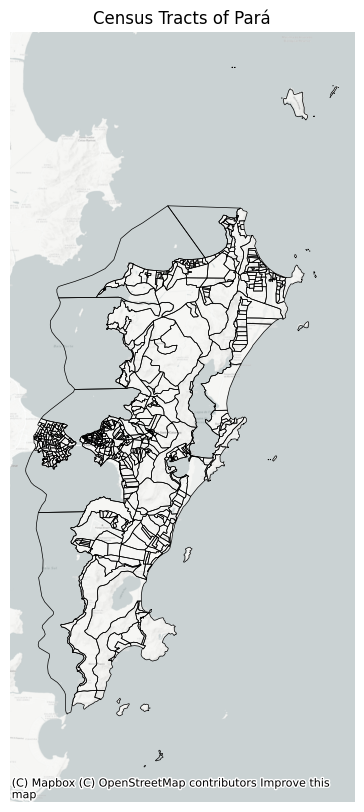

In [28]:
ax = flor_cntr.plot(
    facecolor="none", edgecolor="black", linewidth=0.5, figsize=(10, 10)
)

# Set title and legend
ax.set_title("Census Tracts of Pará")

# Add basemap
cx.add_basemap(ax, crs=flor_cntr.crs.to_string(), source=BASEMAP_WHITE)

# Remove axis
ax.set_axis_off()

plt.savefig(
    f"outputs/maps/{city}/04-{city}_census_tracts.png", dpi=300, bbox_inches="tight"
)

plt.show()

We can clearly visualize that the census tracts differ in size depeding on the geographical location. For example, near city centers, the census tracts are smaller, while in the peri-urban areas, the census tracts are bigger. 

There are some census tracts that seems to be on the ocean, we should handle them.

Now, we will read a [dataset generated with the `CensoBR` R package here](link-to-r-notebook). In this dataset we have census variables such as Income and Population by Age that are useful to identify areas where schools are needed.

In [29]:
sc_censobr_tract_income = pd.read_csv("data/flor_censobr_tract_income.csv", index_col=0)

In [30]:
print(
    "Number of census tracts obtainer in R for Santa Catarina State:",
    len(sc_censobr_tract_income),
)

Number of census tracts obtainer in R for Santa Catarina State: 308993


In [31]:
sc_censobr_tract_income.head()

code_tract  V002      V003  pessoa01_V021  pessoa01_V022  \
1  354660305000050     7       NaN            NaN            NaN   
2  354660305000051     2       NaN            NaN            NaN   
3  354670205000001   569  495793.0           14.0           13.0   
4  354670205000002   422  330949.0            9.0            6.0   
5  354670205000003   722  570807.0           15.0           10.0   

   pessoa01_V023  pessoa01_V024  pessoa01_V025  pessoa01_V026  pessoa01_V027  \
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3            4.0            7.0            9.0            8.0            8.0   
4           10.0            7.0            7.0            8.0           10.0   
5           10.0           12.0           18.0           14.0           17.0   

   ...  pessoa01_V044  pessoa01_V045  pessoa01_V046  pessoa01_V047  \
1  ...            NaN            NaN            NaN            NaN   
2  ...            NaN            NaN            NaN            NaN   
3  ...           11.0            5.0            6.0            8.0   
4  ...            4.0            3.0            4.0           10.0   
5  ...            8.0           10.0           14.0           11.0   

   pessoa01_V048  pessoa01_V049  pessoa01_V050  pessoa01_V051  pessoa01_V052  \
1            NaN            NaN            NaN            NaN            NaN   
2            NaN            NaN            NaN            NaN            NaN   
3           11.0           10.0            4.0           10.0            3.0   
4            4.0            8.0            4.0            2.0            3.0   
5            4.0           11.0           14.0            9.0            6.0   

    income_pc  
1         NaN  
2         NaN  
3  871.340949  
4  784.239336  
5  790.591413  

[5 rows x 36 columns]

In [32]:
# Verify code_tract values have the same type in both datasets
print("Type of code_tract in para_cntr:", sc_censobr_tract_income.code_tract.dtype)
print("Type of code_tract in censobr_tract_income:", sc_cntr.code_tract.dtype)

Type of code_tract in para_cntr: int64
Type of code_tract in censobr_tract_income: object


In [33]:
sc_cntr["code_tract"] = sc_cntr["code_tract"].astype("int64")

In [34]:
print(
    "Number of census tracts with associated data:",
    sc_censobr_tract_income["code_tract"].isin(sc_cntr["code_tract"].unique()).sum(),
)

Number of census tracts with associated data: 11858


In [35]:
# Merge datasets to visualize census data in maps
sc_cntr_income = sc_cntr.merge(
    sc_censobr_tract_income, left_on="code_tract", right_on="code_tract", how="left"
)

In [45]:
flor_cntr_income = sc_cntr_income.query("code_muni == 4205407")

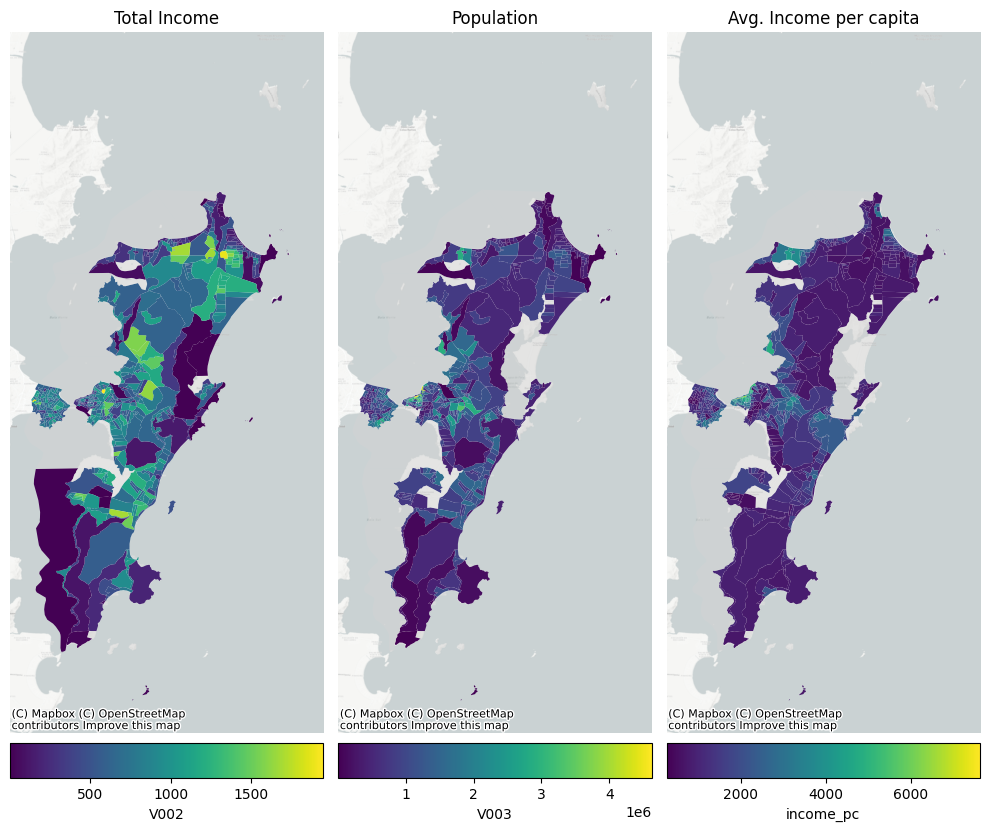

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(10, 30))

cols = ["V002", "V003", "income_pc"]
titles = ["Total Income", "Population", "Avg. Income per capita"]

for ax, col, title in zip(axes, cols, titles):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    flor_cntr_income.plot(
        ax=ax,
        column=col,
        cmap="viridis",
        cax=cax,
        legend=True,
        legend_kwds={"label": col, "orientation": "horizontal"},
        missing_kwds={"color": "lightgrey", "alpha": 0.5},
    )
    ax.set_title(title)
    ax.set_axis_off()
    cx.add_basemap(ax, crs=sc_state.crs.to_string(), source=BASEMAP_WHITE)

plt.tight_layout()

plt.savefig(
    f"outputs/maps/{city}/05-{city}_census_tract_data.png", dpi=300, bbox_inches="tight"
)

Now we will aggregate population by age variables according to the brazilian school levels:

- Infantil: 3 months to 5 years old
- Elementary: 6 to 14 years old
- Middle: 15 to 17 years old
- High: 18 years old

In [47]:
# Between 3 months and 5 years old
cols_infantil = [f"pessoa01_V{i:03d}" for i in range(26, 40)]
flor_cntr_income["pop_3_5_years"] = flor_cntr_income[cols_infantil].sum(axis=1)
# Between 6 and 14 years old
cols_fundamental = [f"pessoa01_V{i:03d}" for i in range(40, 49)]
flor_cntr_income["pop_6_14_years"] = flor_cntr_income[cols_fundamental].sum(axis=1)
# Between 15 and 17 years old
cols_medio = [f"pessoa01_V{i:03d}" for i in range(49, 52)]
flor_cntr_income["pop_15_17_years"] = flor_cntr_income[cols_medio].sum(axis=1)
# 18 years old or more
cols_superior = ["pessoa01_V052"]
flor_cntr_income["pop_18_years"] = flor_cntr_income[cols_superior].sum(axis=1)

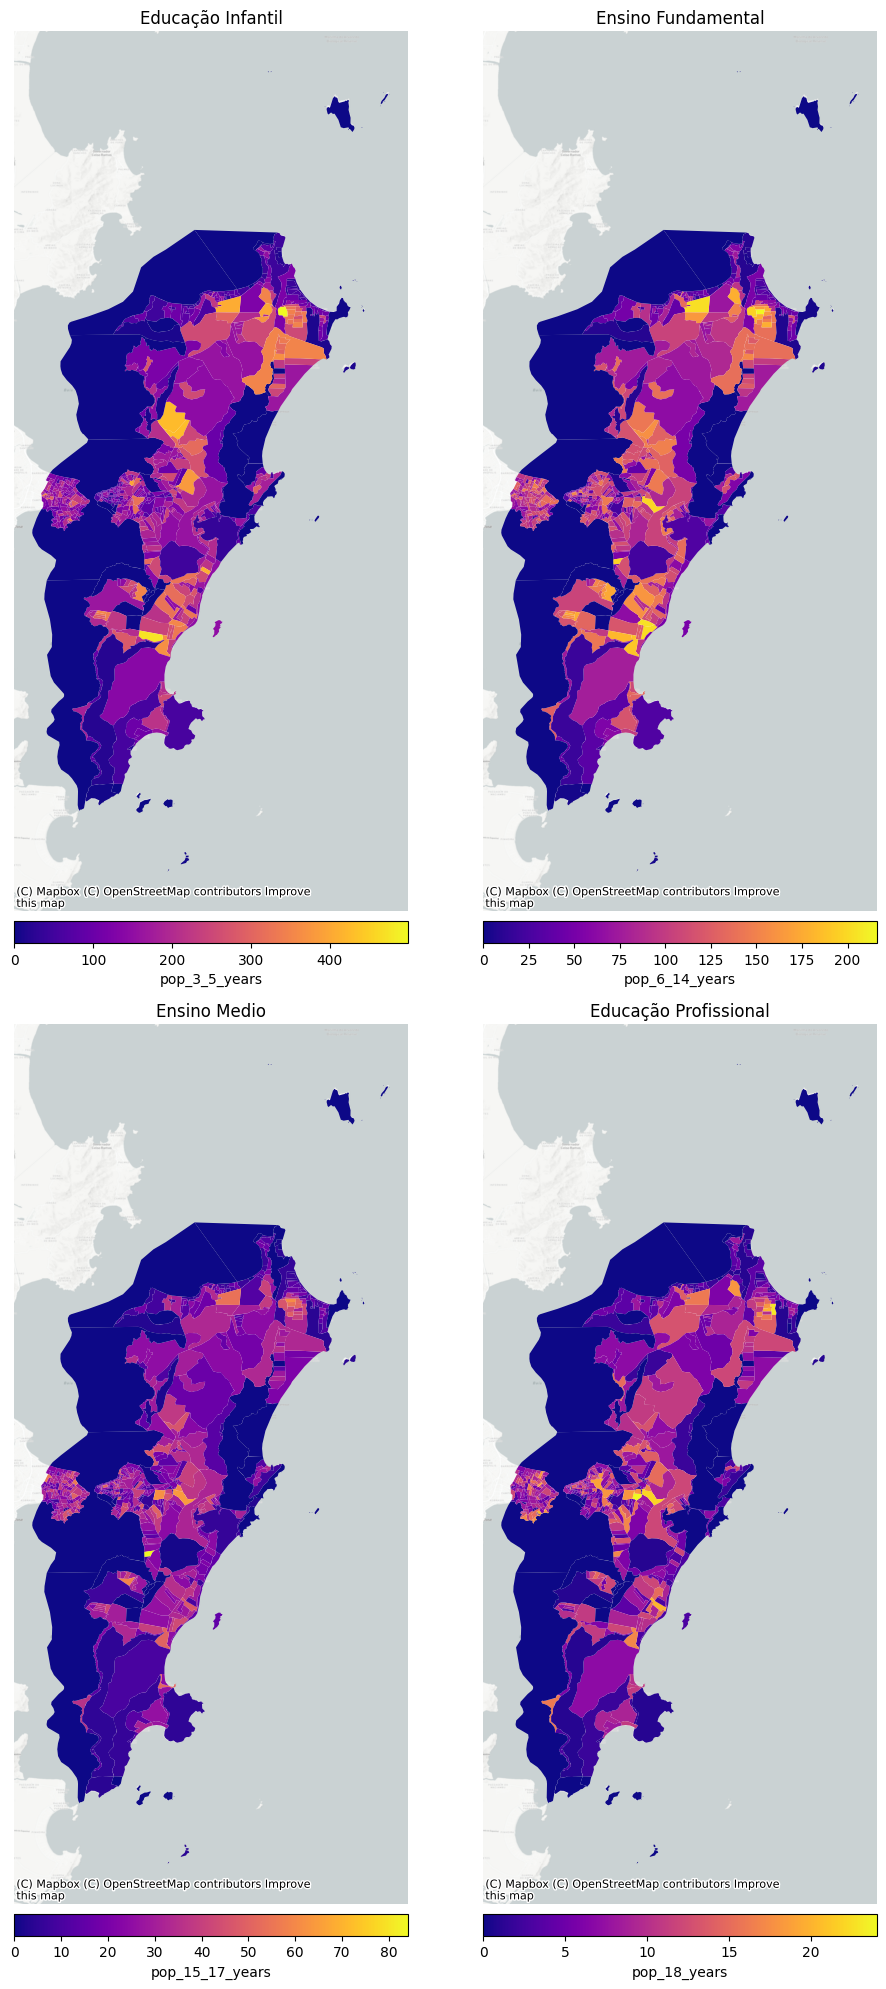

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(10, 20))

cols = ["pop_3_5_years", "pop_6_14_years", "pop_15_17_years", "pop_18_years"]
titles = [
    "Educação Infantil",
    "Ensino Fundamental",
    "Ensino Medio",
    "Educação Profissional",
]

for ax, col, title in zip(axes.flatten(), cols, titles):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.1)
    flor_cntr_income.plot(
        ax=ax,
        column=col,
        cmap="plasma",
        legend=True,
        legend_kwds={"label": col, "orientation": "horizontal"},
        missing_kwds={"color": "lightgrey"},
        cax=cax,
    )
    ax.set_title(title)
    ax.set_axis_off()
    cx.add_basemap(ax, crs=sc_state.crs.to_string(), source=BASEMAP_WHITE)

plt.tight_layout()

plt.savefig(
    f"outputs/maps/{city}/06-{city}_state_pop_by_edulevel.png",
    dpi=300,
    bbox_inches="tight",
)

### Step 2.2. Download Meta's High Resolution Population Density

Let's see all the available datasets for Brazil in Humanitarian Data Exchange (HDX).

In [49]:
brazil_hdx_datasets = up.download.search_hdx_dataset("brazil")
brazil_hdx_datasets

created                                               name  \
id                                                                  
0   2019-06-11         BRA_children_under_five_2019-06-01_csv.zip   
1   2019-06-11             BRA_elderly_60_plus_2019-06-01_csv.zip   
2   2019-06-11                         BRA_men_2019-06-01_csv.zip   
26  2019-06-11                       BRA_women_2019-06-01_csv.zip   
27  2019-06-11  BRA_women_of_reproductive_age_15_49_2019-06-01...   
28  2019-06-11                 BRA_youth_15_24_2019-06-01_csv.zip   
33  2019-06-25       population_bra_northeast_2018-10-01.csv..zip   
34  2019-06-25        population_bra_northwest_2018-10-01.csv.zip   
35  2019-06-25        population_bra_southeast_2018-10-01.csv.zip   
36  2019-06-25        population_bra_southwest_2018-10-01.csv.zip   

                                population  size_mb  \
id                                                    
0                      Children (ages 0-5)   159.14   
1                       Elderly (ages 60+)   159.42   
2                                      Men   160.20   
26                                   Women   160.21   
27  Women of reproductive age (ages 15-49)   160.03   
28                     Youth (ages 15-24)    159.79   
33              Overall population density    71.24   
34              Overall population density    13.46   
35              Overall population density   159.42   
36              Overall population density    45.96   

                                                  url  
id                                                     
0   https://data.humdata.org/dataset/c17003d1-47f4...  
1   https://data.humdata.org/dataset/c17003d1-47f4...  
2   https://data.humdata.org/dataset/c17003d1-47f4...  
26  https://data.humdata.org/dataset/c17003d1-47f4...  
27  https://data.humdata.org/dataset/c17003d1-47f4...  
28  https://data.humdata.org/dataset/c17003d1-47f4...  
33  https://data.humdata.org/dataset/c17003d1-47f4...  
34  https://data.humdata.org/dataset/c17003d1-47f4...  
35  https://data.humdata.org/dataset/c17003d1-47f4...  
36  https://data.humdata.org/dataset/c17003d1-47f4...

We will download the **Overall population density** dataset from HDX. This dataset contains the population density of Brazil at 30m2 resolution.

In [51]:
pop_type = "Overall population density"  # This could be specified depending on the census population age group

In [52]:
%%time
if os.path.exists("outputs/pop_general_flor.parquet"):
    pop_general_flor = gpd.read_parquet("outputs/pop_general_flor.parquet")
else:
    pop_general_brazil = up.download.get_hdx_dataset(
        resources_df=brazil_hdx_datasets,
        ids=brazil_hdx_datasets.query("population == @pop_type").index.tolist(),
    )
    pop_general_flor = up.geom.filter_population(pop_general_brazil, flor_muni)
    pop_general_flor.to_parquet("outputs/pop_general_flor.parquet")

CPU times: user 287 ms, sys: 57 ms, total: 344 ms
Wall time: 2.58 s


The obtained dataset is simple and contains the following columns:

In [53]:
pop_general_flor.head()

latitude  longitude  population_2015  population_2020  \
887751 -27.853472 -48.606528         0.518908         0.582712   
887752 -27.853472 -48.606250         0.518908         0.582712   
887753 -27.853472 -48.605972         0.518908         0.582712   
887754 -27.853472 -48.605694         0.518908         0.582712   
887755 -27.853472 -48.605139         0.518908         0.582712   

                           geometry  
887751  POINT (-48.60653 -27.85347)  
887752  POINT (-48.60625 -27.85347)  
887753  POINT (-48.60597 -27.85347)  
887754  POINT (-48.60569 -27.85347)  
887755  POINT (-48.60514 -27.85347)

In [54]:
print("Number population data points for Florianopolis:", len(pop_general_flor))

Number population data points for Florianopolis: 65086


### Step 2.3.  Aggregate Population Density in Hexagons (Uniform Spatial Units)

In [55]:
if os.path.exists("outputs/flor_hexs.parquet"):
    flor_hexs = gpd.read_parquet("outputs/flor_hexs.parquet")
else:
    flor_hexs = up.geom.gen_hexagons(resolution=8, city=flor_muni)
    flor_hexs.to_parquet("outputs/flor_hexs.parquet")

In [56]:
%%time
flor_hexs_pop = up.geom.merge_shape_hex(
    hexs=flor_hexs,
    shape=pop_general_flor,
    agg={
        "population_2020": "sum",
    },
)

CPU times: user 101 ms, sys: 3.75 ms, total: 105 ms
Wall time: 300 ms


In [57]:
# Check if there are duplicated hexagons
flor_hexs_pop["hex"].duplicated().sum()

0

In [58]:
# Verify the integrity of the data size
flor_hexs.shape, flor_hexs_pop.shape

((989, 2), (989, 3))

### Step 2.4. Convert Census Tract Level Data to Hexagons Level

Census tract level numerical variables like population and income will be divided in hexagons proportionally to the Meta high-resolution population density.

In [59]:
# Verify crs are the same
flor_hexs.crs.to_string(), flor_cntr_income.crs.to_string()

('EPSG:4326', 'EPSG:4674')

In [60]:
# if not make them the same
para_cntr_income = flor_cntr_income.to_crs(flor_hexs.crs)

In [61]:
# # Population divided in hexagons proportionally to the area of the census tracts (not interesting for this case)
# pop_hexs_pops_census = up.geom.overlay_polygons_hexs(
#     polygons=para_cntr_income,
#     hexs=para_hexs_pop,
#     hex_col="hex",
#     columns=["pop_3_5_years", "pop_6_14_years", "pop_15_17_years", "pop_18_years", "V002", "V003"],
# )

# pop_hexs_pops_census.head()

In [75]:
# Downscaling helper functions
def min_max(x):
    return (x - x.min()) / (x.max() - x.min())


def downscale_proportionally(x, cols, prop_col):
    scaled_proportion = (x[prop_col] - x[prop_col].min()) / (
        x[prop_col].max() - x[prop_col].min()
    )
    downscaled_values = []
    for col in cols:
        col_downscaled = x[col].unique()[0] * scaled_proportion
        col_downscaled.name = col + "_adj"
        downscaled_values.append(col_downscaled)

    return pd.concat(downscaled_values, axis=1)

In [129]:
# Downscaling function
def proportional_overlay(shape, id_col, prop_col, hexs, hex_col, colums):
    """
    Downscale the input "shape" geodataframe using the "hexs" geodataframe "prop_col" column to proportionally downscale the specified columns.

    Parameters
    ----------
    shape : geopandas.GeoDataFrame
        Geodataframe to be downscaled.
    id_col : str
        Column name of the shape geodataframe to be used as index.
    prop_col : str
        Column name of the hexagons geodataframe to be used as proportion.
    hexs : geopandas.GeoDataFrame
        Geodataframe to be used as overlay.
    hex_col : str
        Column name of the hexagons geodataframe to be used as index.
    colums : list
        List of columns to be downscaled.

    Returns
    -------

    hex_gdf : geopandas.GeoDataFrame
        Geodataframe with downscaled columns.

    Examples
    --------

    Here is an visual representantion of what this function does:

    +-----------------+
    |                 |
    |  +-----------+  |                           +-----------+
    |  |           |  |                           |           |
    |  |     w_0   |  |                           |   x_adj   |
    |  |    0.4    |  |                           |    40     |
    |  |           |  |                           |           |
    |  +-----------+  |                           +-----------+
    |        x        |
    |       100       |      ----------------->
    |                 |
    |  +-----------+  |                           +-----------+
    |  |     w_1   |  |                           |   x_adj   |
    |  |    0.6    |  |                           |    60     |
    |  |           |  |                           |           |
    |  |           |  |                           |           |
    |  +-----------+  |                           +-----------+
    |                 |
    +-----------------+

    Where:
    - x is the value of the variable to be downscaled
    - w_i is the proportion of the hexagon area that overlaps with the shape
    - x_adj is the downscaled value of x

    """

    # Overlay intersection (this operation is time expensive)
    overlayed = gpd.overlay(shape, hexs, how="intersection")

    # Downsample census variables using proportional to Meta's population density
    if hasattr(overlayed, "progress_apply"):
        overlayed_scaled = overlayed.groupby(id_col).progress_apply(
            downscale_proportionally,
            prop_col=prop_col,
            cols=colums,
        )
    else:
        print("Activate tqdm.pandas() to see progress bar")
        overlayed_scaled = overlayed.groupby(id_col).apply(
            downscale_proportionally,
            prop_col=prop_col,
            cols=colums,
        )

    processed_cols = overlayed_scaled.columns.tolist()

    overlayed_scaled_complete = overlayed.merge(
        overlayed_scaled.reset_index().drop(id_col, axis=1),
        left_index=True,
        right_on="level_1",  # TODO: Specify overlayed_index programatically
        how="left",
    )

    per_hexagon_data = overlayed_scaled_complete.groupby(hex_col)[processed_cols].sum()

    # Preserve data as GeoDataFrame
    hex_df = hexs.merge(per_hexagon_data, on=hex_col, how="left")
    hex_gdf = gpd.GeoDataFrame(hex_df.copy(), crs=hexs.crs)

    # Conserve nan values of the original variable used to downscale proportionaly
    for col in processed_cols:
        nans_filter = hex_gdf[hex_gdf[prop_col].isna() & (hex_gdf[col] == 0)].index
        hex_gdf.loc[nans_filter, col] = np.nan

    return hex_gdf

In [130]:
flor_hexs_pop.head()

hex                                           geometry  \
0  88a91bcd09fffff  POLYGON ((-48.50489 -27.84191, -48.50072 -27.8...   
1  88a91bcd51fffff  POLYGON ((-48.52335 -27.84365, -48.51917 -27.8...   
2  88a91b425bfffff  POLYGON ((-48.46311 -27.69699, -48.45893 -27.6...   
3  88a91b5565fffff  POLYGON ((-48.46642 -27.70402, -48.46224 -27.7...   
4  88a91b4d57fffff  POLYGON ((-48.35799 -27.49173, -48.35381 -27.4...   

   population_2020  
0              NaN  
1              NaN  
2        19.249137  
3         9.624569  
4              NaN

In [131]:
# Columns to process
cols = [
    "pop_3_5_years",
    "pop_6_14_years",
    "pop_15_17_years",
    "pop_18_years",
    "V002",
    "V003",
]

In [132]:
hex_gdf = proportional_overlay(
    shape=flor_cntr_income,
    id_col="code_tract",
    prop_col="population_2020",
    hexs=flor_hexs_pop,
    hex_col="hex",
    colums=cols,
)

  0%|          | 0/651 [00:00<?, ?it/s]

In [133]:
hex_gdf.isna().sum()

hex                      0
geometry                 0
population_2020        474
pop_3_5_years_adj      474
pop_6_14_years_adj     474
pop_15_17_years_adj    474
pop_18_years_adj       474
V002_adj               474
V003_adj               474
dtype: int64

Compare the total number of census tracts and hexagons in Florianopolis

In [134]:
print("Census Tracts:", flor_cntr_income.shape[0], "-->", "Hexagons:", hex_gdf.shape[0])

Census Tracts: 651 --> Hexagons: 989


### Step 2.5. Visualize downsampled population data in hexagons

Let's see how the population and income data looks like in the hexagons. Visualizing data side by side is a good way to see if the data is consistent.

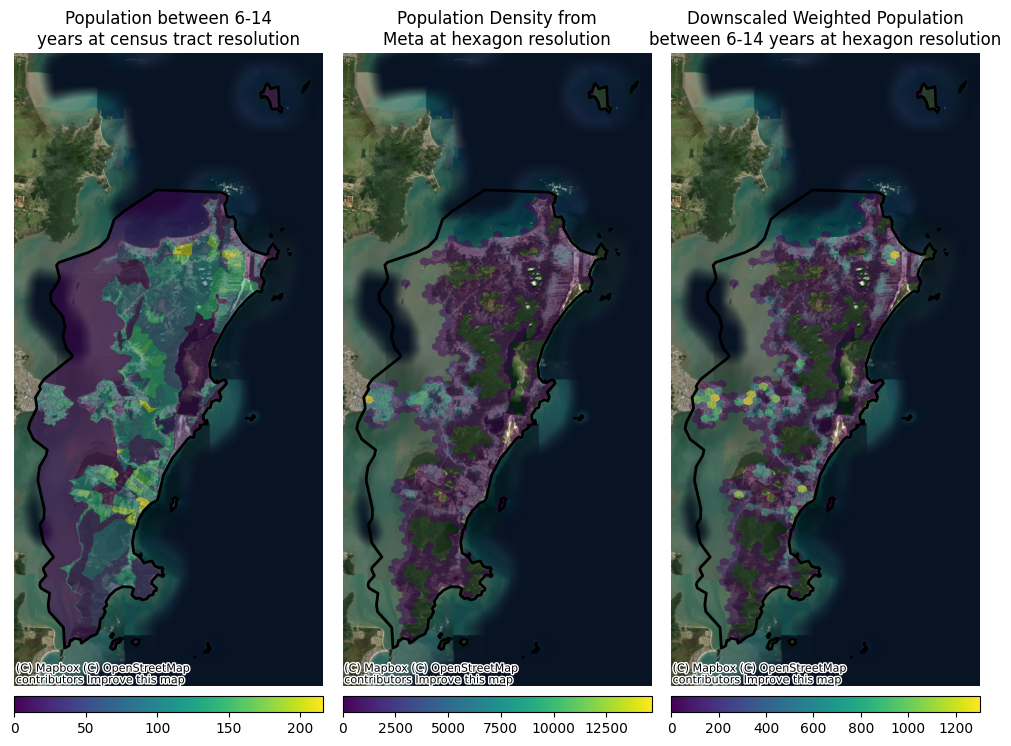

In [140]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 30))

ax1.set_title("Population between 6-14\nyears at census tract resolution")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="2.5%", pad=0.1)
(
    flor_cntr_income.clip(
        flor_hexs_pop.unary_union.envelope
    ).plot(  # Clip to make all plots the same size
        "pop_6_14_years",
        ax=ax1,
        alpha=0.5,
        legend=True,
        cax=cax,
        legend_kwds={"orientation": "horizontal"},
    )
)
flor_muni.plot(facecolor="none", edgecolor="k", linewidth=2, ax=ax1)

ax2.set_title("Population Density from\nMeta at hexagon resolution")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="2.5%", pad=0.1)
flor_hexs_pop.plot(
    "population_2020",
    ax=ax2,
    alpha=0.5,
    legend=True,
    cax=cax,
    legend_kwds={"orientation": "horizontal"},
)
flor_muni.plot(facecolor="none", edgecolor="k", linewidth=2, ax=ax2)

ax3.set_title(
    "Downscaled Weighted Population\nbetween 6-14 years at hexagon resolution"
)
divider = make_axes_locatable(ax3)
cax = divider.append_axes("bottom", size="2.5%", pad=0.1)
hex_gdf.plot(
    "pop_6_14_years_adj",
    ax=ax3,
    alpha=0.5,
    legend=True,
    cax=cax,
    legend_kwds={"orientation": "horizontal"},
)
flor_muni.plot(facecolor="none", edgecolor="k", linewidth=2, ax=ax3)

for ax in ax1, ax2, ax3:
    cx.add_basemap(ax, crs=flor_cntr_income.crs.to_string(), source=BASEMAP)
    ax.set_axis_off()

plt.tight_layout()

plt.savefig(
    f"outputs/maps/{city}/07-{city}_downscaled_pop.png", dpi=300, bbox_inches="tight"
)

Another way to check population consistency is to compare population distribution with road network density. The idea is that areas with higher population density should have more roads.

In [142]:
# download network from geometry
flor_muni_income_g = ox.graph_from_polygon(flor_muni.unary_union, network_type="drive")

In [143]:
# Convert the graph to geodataframe
flor_muni_income_gdf = ox.graph_to_gdfs(flor_muni_income_g, nodes=False)

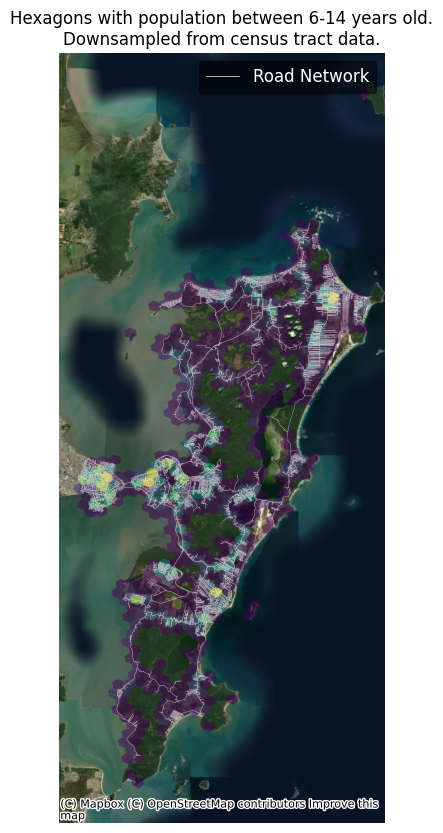

In [144]:
# plot the graph
fig, ax = plt.subplots(figsize=(10, 10))

# overlay the hexagons population
flor_muni_income_gdf.plot(ax=ax, facecolor="none", edgecolor="white", linewidth=0.1)
hex_gdf.plot("pop_6_14_years_adj", ax=ax, alpha=0.5, legend=True, cax=cax)

# Create line2D objects with labels
legend_labels = ["Road Network"]
colors = ["white"]
linewidths = [0.5]
legend_handles = [
    plt.Line2D([0], [0], color=colors[0], linewidth=linewidths[0], linestyle="-")
]

# Set title and legend
ax.set_title(
    "Hexagons with population between 6-14 years old.\nDownsampled from census tract data."
)
# Make font color white
ax.legend(
    legend_handles,
    legend_labels,
    loc="upper right",
    framealpha=0.5,
    facecolor="black",
    edgecolor="black",
    fontsize=12,
)
# Make font color white
for text in ax.get_legend().get_texts():
    text.set_color("white")

# Add basemap
cx.add_basemap(ax, crs=flor_hexs_pop.crs.to_string(), source=BASEMAP)
ax.set_axis_off()

plt.savefig(
    f"outputs/maps/{city}/08-{city}_hexspop_roadnetwork.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()

We can clearly observe that the population values mostly are located around the road network. This is a good sign that our downscaling method is working as expected. Also, higher population values correspond to higher density of roads.


### Step 2.6. Calculate and visualize income per capita

In [145]:
hex_gdf["income_pc"] = hex_gdf["V003_adj"] / hex_gdf["V002_adj"]

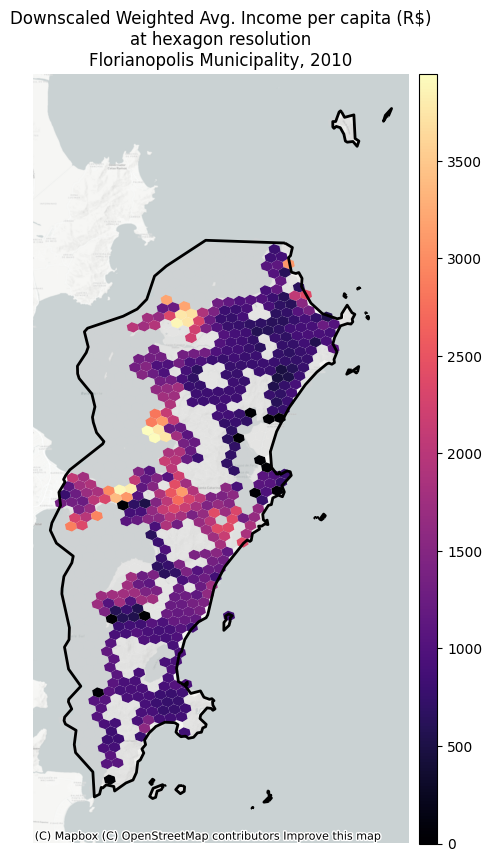

In [149]:
fig, ax = plt.subplots(figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

ax.set_title(
    "Downscaled Weighted Avg. Income per capita (R$)\nat hexagon resolution\nFlorianopolis Municipality, 2010"
)
hex_gdf.plot(
    "income_pc",
    ax=ax,
    cmap="magma",
    legend=True,
    missing_kwds={"color": "lightgrey", "alpha": 0.5},
    cax=cax,
)
flor_muni.plot(facecolor="none", edgecolor="k", linewidth=2, ax=ax)
ax.set_axis_off()

cx.add_basemap(ax, crs=hex_gdf.crs.to_string(), source=BASEMAP_WHITE)

## Step 3. Extract and process Schools geographical data

In [150]:
if os.path.exists("outputs/br_schools.parquet"):
    br_schools = gpd.read_parquet("outputs/br_schools.parquet")
else:
    br_schools = geobr.read_schools()
    br_schools.to_parquet("outputs/br_schools.parquet")

In [151]:
# Convert Schools CRS to match hexagons
br_schools = br_schools.to_crs(hex_gdf.crs)

In [152]:
print("Number of schools in Brazil:", len(br_schools))

Number of schools in Brazil: 222936


In [153]:
br_schools.head()

abbrev_state    name_muni  code_school  \
0           RO  Porto Velho     11000023   
1           RO  Porto Velho     11000040   
2           RO  Porto Velho     11000058   
3           RO  Porto Velho     11000082   
4           RO  Porto Velho     11000104   

                                       name_school  \
0               EEEE ABNAEL MACHADO DE LIMA - CENE   
1                         EMEIEF PEQUENOS TALENTOS   
2                        CENTRO DE ENSINO CLASSE A   
3  CENTRO EDUCACIONAL PRESBITERIANO 15 DE NOVEMBRO   
4                        CENTRO EDUC CORA CORALINA   

                                     education_level  \
0                                 Ensino Fundamental   
1                                  Educação Infantil   
2  Educação Infantil, Ensino Fundamental, Ensino ...   
3              Educação Infantil, Ensino Fundamental   
4              Educação Infantil, Ensino Fundamental   

                  education_level_others admin_category  \
0  Atendimento Educacional Especializado        Pública   
1                                               Pública   
2                                               Privada   
3                                               Privada   
4                                               Privada   

                                             address    phone_number  \
0  AVENIDA AMAZONAS, 6492 ZONA LESTE. TIRADENTES....  (69) 992083054   
1  RUA CAETANO, 3256 PREDIO. CALADINHO. 76808-108...   (69) 32135237   
2  AVENIDA CARLOS GOMES, 1135 CENTRO. 76801-123 P...   (69) 32244473   
3  RUA ALMIRANTE BARROSO, 1483 SANTA BARBARA. 768...   (69) 32245636   
4  RUA MEXICO, 1056 NOVA PORTO VELHO. 76820-190 P...   (69) 32252616   

  government_level private_school_type private_government_partnership  \
0         Estadual       Não Informado                            Não   
1        Municipal       Não Informado                            Não   
2          Privada          Particular                            Não   
3          Privada          Particular                            Não   
4          Privada          Particular                            Não   

  regulated_education_council  \
0                         Não   
1                         Sim   
2                         Sim   
3                         Sim   
4                         Sim   

                                 service_restriction  \
0  ESCOLA ATENDE EXCLUSIVAMENTE ALUNOS COM DEFICI...   
1  ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...   
2  ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...   
3  ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...   
4  ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...   

                                           size   urban  \
0    Entre 51 e 200 matrículas de escolarização  Urbana   
1   Entre 201 e 500 matrículas de escolarização  Urbana   
2      Mais de 1000 matrículas de escolarização  Urbana   
3    Entre 51 e 200 matrículas de escolarização  Urbana   
4  Entre 501 e 1000 matrículas de escolarização  Urbana   

                                       location_type date_update  \
0  A escola não está em área de localização difer...  2020-10-18   
1  A escola não está em área de localização difer...  2020-10-18   
2  A escola não está em área de localização difer...  2020-10-18   
3  A escola não está em área de localização difer...  2020-10-18   
4  A escola não está em área de localização difer...  2020-10-18   

                     geometry  
0  POINT (-63.85401 -8.75846)  
1  POINT (-63.88392 -8.79373)  
2  POINT (-63.90199 -8.76073)  
3  POINT (-63.89618 -8.76520)  
4  POINT (-63.87547 -8.76863)

### Step 3.1. Aggregate categorical variables in hexagons

To work with categorical data we have to convert from text to numerical values. To do this we will create one column for each class in the caterogical variable and fill with 1 if the school belongs to that class and 0 otherwise. This process is known as One or Multi-hot encoding.

In [154]:
mlb_edu = MultiLabelBinarizer(
    classes=[
        "Ensino Fundamental",
        "Educação Infantil",
        "Ensino Médio",
        "Educação de Jovens Adultos",
        "Educação Profissional",
        "",
    ]
)
edu_level = pd.DataFrame(
    mlb_edu.fit_transform(br_schools["education_level"].str.split(", ")),
    columns=mlb_edu.classes_,
    index=br_schools.index,
)
edu_level.columns = [
    "ensino_fundamental",
    "educacao_infantil",
    "ensino_medio",
    "educacao_jovens_adultos",
    "educacao_profissional",
    "no_specified",
]

Example of education level columns assigned to the schools:

In [155]:
edu_level.head()

ensino_fundamental  educacao_infantil  ensino_medio  \
0                   1                  0             0   
1                   0                  1             0   
2                   1                  1             1   
3                   1                  1             0   
4                   1                  1             0   

   educacao_jovens_adultos  educacao_profissional  no_specified  
0                        0                      0             0  
1                        0                      0             0  
2                        0                      0             0  
3                        0                      0             0  
4                        0                      0             0

In [156]:
br_schools = br_schools.assign(**edu_level.to_dict())

In [157]:
mlb_admin = MultiLabelBinarizer(classes=["Pública", "Privada"])
admin_cat = pd.DataFrame(
    mlb_admin.fit_transform(br_schools["admin_category"].str.split(", ")),
    columns=mlb_admin.classes_,
    index=br_schools.index,
)
admin_cat.columns = ["publica", "privada"]

Example of administrative category columns assigned to the schools:

In [158]:
admin_cat.head()

publica  privada
0        1        0
1        1        0
2        0        1
3        0        1
4        0        1

In [159]:
br_schools = br_schools.assign(**admin_cat.to_dict())

In [161]:
sc_schools = br_schools.query("abbrev_state == 'SC'")

In [162]:
sc_schools.shape

(7213, 27)

In [163]:
flor_schools = sc_schools.query("name_muni == 'Florianópolis'")

In [164]:
# Verify integrity of code_school as unique identifier
flor_schools.shape, flor_schools["code_school"].unique().shape

((351, 27), (351,))

In [165]:
# Count number of schools hexagon using urbanpy
hex_gdf = up.geom.merge_shape_hex(
    hexs=hex_gdf,
    shape=flor_schools,
    agg={
        # Education level
        "ensino_fundamental": "sum",
        "educacao_infantil": "sum",
        "ensino_medio": "sum",
        "educacao_jovens_adultos": "sum",
        "educacao_profissional": "sum",
        "no_specified": "sum",
        # Admin category
        "publica": "sum",
        "privada": "sum",
    },
)

Once aggregated the categorical variables, we can visualize the number of schools per hexagon.
We will overlay the schools points to see if the aggregation is working as expected.

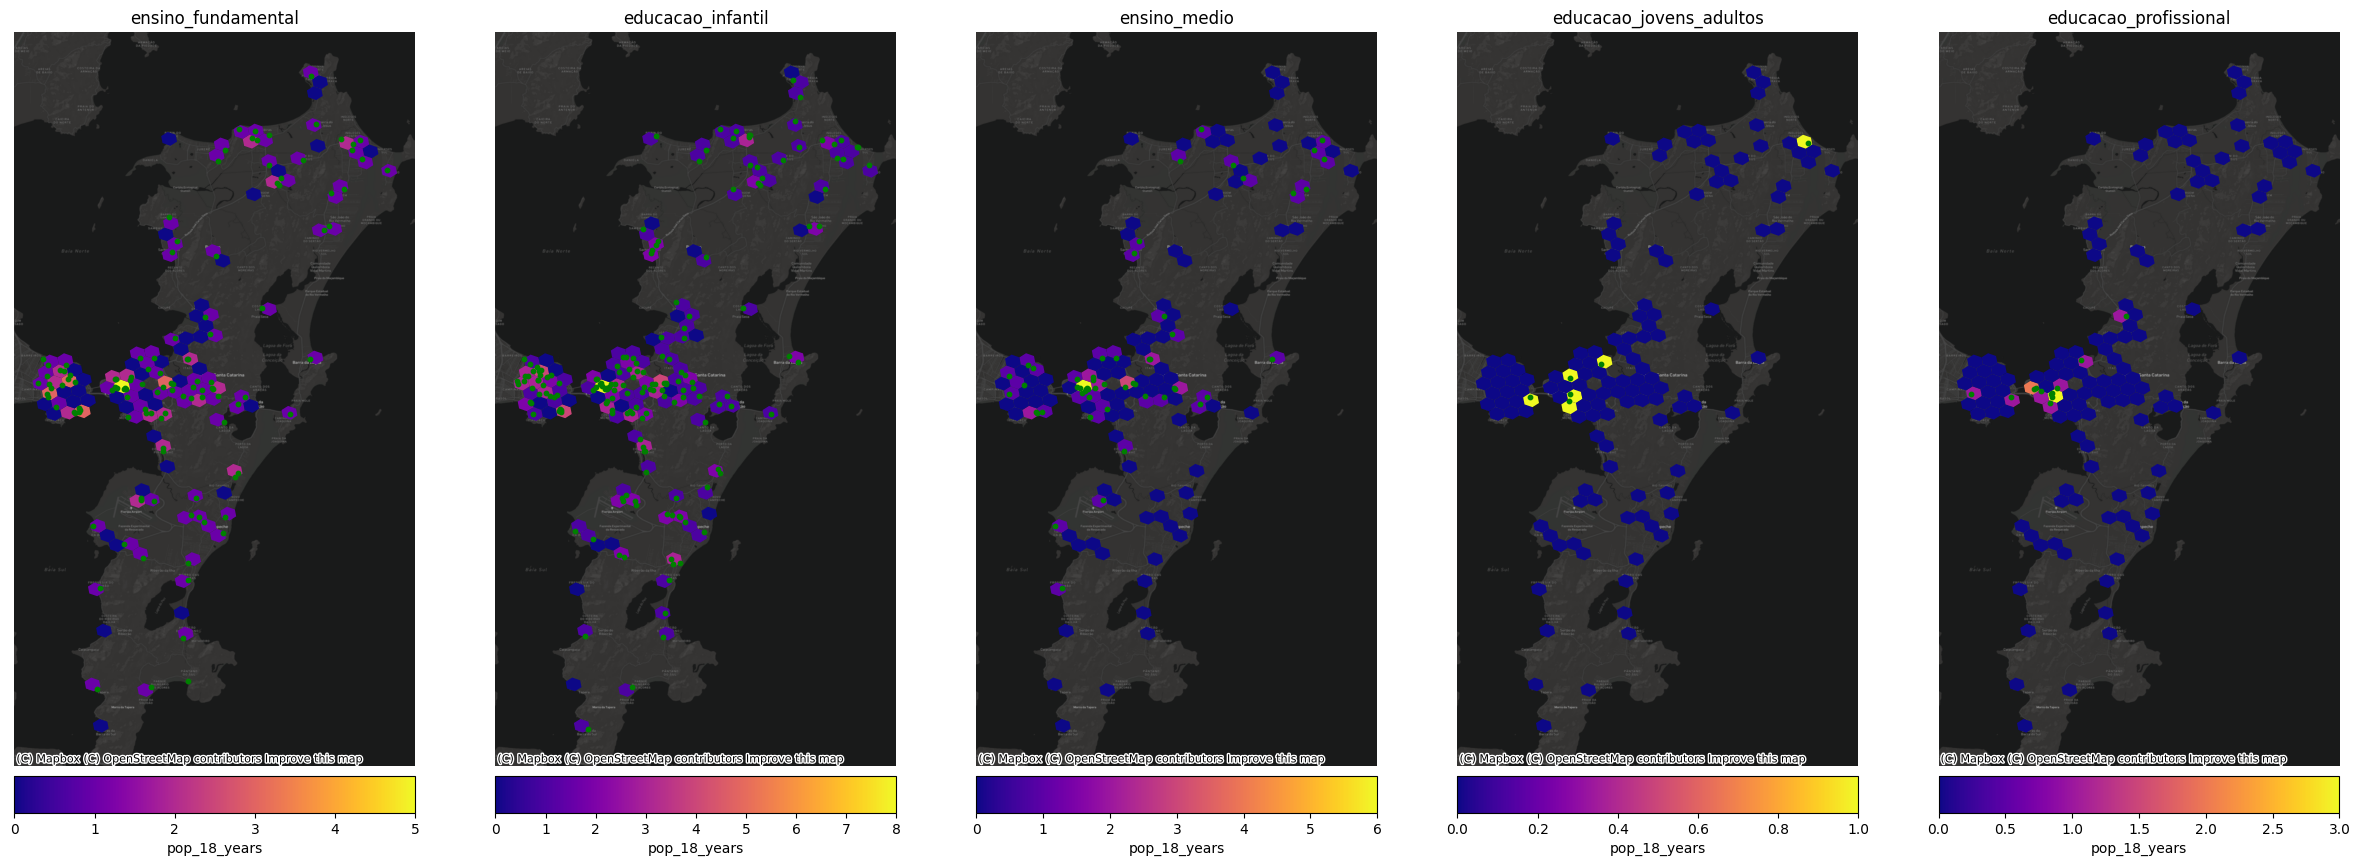

In [177]:
edu_levels = [
    "ensino_fundamental",
    "educacao_infantil",
    "ensino_medio",
    "educacao_jovens_adultos",
    "educacao_profissional",
]

fig, axes = plt.subplots(1, 5, figsize=(30, 20))

for ax, edu_level in zip(axes, edu_levels):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.1)
    ax.set_title(edu_level)
    hex_gdf.plot(
        edu_level,
        ax=ax,
        cmap="plasma",
        legend=True,
        cax=cax,
        legend_kwds={"label": col, "orientation": "horizontal"},
    )
    flor_schools.query(f"{edu_level} == 1").plot(color="green", ax=ax, markersize=10)
    ax.set_axis_off()
    cx.add_basemap(ax, crs=hex_gdf.crs.to_string(), source=BASEMAP_DARK)

# plt.tight_layout()

plt.savefig(
    f"outputs/maps/{city}/09-{city}_schools_hex.png", dpi=300, bbox_inches="tight"
)

Schools distribution seems to be consistent with the population distribution. This is a good sign that our aggregation method is working as expected.

### Step 3.2. Aggregate numerical variables in hexagons

In this official dataset provided by IBGE, we don't have the enrollment data. We will use the enrollment data from the a previous schools dataset to estimate the number of students per school and hexagon.

In [167]:
# Read escuelas.csv
escuelas = pd.read_csv("data/escuelas.csv", skiprows=1)

In [168]:
escuelas.head()

Restrição de Atendimento  \
0  ESCOLA ATENDE EXCLUSIVAMENTE ALUNOS COM DEFICI...   
1  ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...   
2  ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...   
3  ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...   
4  ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATE...   

                                            Escola  UF    Município  \
0               EEEE ABNAEL MACHADO DE LIMA - CENE  RO  Porto Velho   
1                        CENTRO DE ENSINO CLASSE A  RO  Porto Velho   
2  CENTRO EDUCACIONAL PRESBITERIANO 15 DE NOVEMBRO  RO  Porto Velho   
3                        CENTRO EDUC CORA CORALINA  RO  Porto Velho   
4                        CENTRO EDUCACIONAL MOJUCA  RO  Porto Velho   

  Localização Categoria Administrativa Dependência Administrativa  \
0      Urbana                  Pública                   Estadual   
1      Urbana                  Privada                    Privada   
2      Urbana                  Privada                    Privada   
3      Urbana                  Privada                    Privada   
4      Urbana                  Privada                    Privada   

  Categoria Escola Privada Conveniada Poder Público  \
0            Não Informado                      Não   
1               Particular                      Não   
2               Particular                      Não   
3               Particular                      Não   
4               Particular                      Não   

  Regulamentação pelo Conselho de Educação  \
0                                      Não   
1                                      Sim   
2                                      Sim   
3                                      Sim   
4                                      Sim   

                                Porte da Escola  \
0    Entre 51 e 200 matrículas de escolarização   
1      Mais de 1000 matrículas de escolarização   
2    Entre 51 e 200 matrículas de escolarização   
3  Entre 501 e 1000 matrículas de escolarização   
4   Entre 201 e 500 matrículas de escolarização   

            Etapas e Modalidade de Ensino Oferecidas  \
0                                 Ensino Fundamental   
1  Educação Infantil, Ensino Fundamental, Ensino ...   
2              Educação Infantil, Ensino Fundamental   
3              Educação Infantil, Ensino Fundamental   
4                   Ensino Fundamental, Ensino Médio   

             Outras Ofertas Educacionais  LAT_FINAL  LONG_FINAL  \
0  Atendimento Educacional Especializado  -8.758459  -63.854011   
1                                    NaN  -8.760734  -63.901986   
2                                    NaN  -8.765205  -63.896177   
3                                    NaN  -8.768633  -63.875471   
4                                    NaN  -8.765028  -63.891857   

   Matriculas totales  Matrículas oficiales  
0               159.0                  94.0  
1              1433.0                1433.0  
2                59.0                  59.0  
3               636.0                 636.0  
4               290.0                 290.0

In [169]:
# convert to geodataframe LAT_FINAL	LONG_FINAL
escuelas_gdf = gpd.GeoDataFrame(
    escuelas,
    geometry=gpd.points_from_xy(escuelas["LONG_FINAL"], escuelas["LAT_FINAL"]),
    crs="EPSG:4326",
)

Separate matriculas by education level to calculate the number of students per hexagon separting by education level and target student population.

In [170]:
# Convert education_level from categorical to multi-hot encoding
mlb_edu = MultiLabelBinarizer(
    classes=[
        "Ensino Fundamental",
        "Educação Infantil",
        "Ensino Médio",
        "Educação de Jovens Adultos",
        "Educação Profissional",
        "",
    ]
)
# Clean NaN values
escuelas_gdf["Etapas e Modalidade de Ensino Oferecidas"] = escuelas_gdf[
    "Etapas e Modalidade de Ensino Oferecidas"
].fillna("")
edu_level = pd.DataFrame(
    mlb_edu.fit_transform(
        escuelas_gdf["Etapas e Modalidade de Ensino Oferecidas"].str.split(", ")
    ),
    columns=mlb_edu.classes_,
    index=escuelas_gdf.index,
)
edu_level.columns = [
    "ensino_fundamental",
    "educacao_infantil",
    "ensino_medio",
    "educacao_jovens_adultos",
    "educacao_profissional",
    "no_specified",
]
edu_level.head()

ensino_fundamental  educacao_infantil  ensino_medio  \
0                   1                  0             0   
1                   1                  1             1   
2                   1                  1             0   
3                   1                  1             0   
4                   1                  0             1   

   educacao_jovens_adultos  educacao_profissional  no_specified  
0                        0                      0             0  
1                        0                      0             0  
2                        0                      0             0  
3                        0                      0             0  
4                        0                      0             0

In [171]:
escuelas_gdf = escuelas_gdf.assign(**edu_level.to_dict())

In [172]:
for level in edu_level.columns:
    escuelas_gdf[f"matric_total_{level}"] = (
        escuelas_gdf[level] * escuelas_gdf["Matriculas totales"]
    )
    escuelas_gdf[f"matric_oficial_{level}"] = (
        escuelas_gdf[level] * escuelas_gdf["Matrículas oficiales"]
    )

In [173]:
# Aggregate matriculas by hexagon
hex_gdf = up.geom.merge_shape_hex(
    hexs=hex_gdf,
    shape=escuelas_gdf,
    agg={
        "Matriculas totales": "sum",
        "Matrículas oficiales": "sum",
    }
    | {f"matric_total_{level}": "sum" for level in edu_level.columns}
    | {f"matric_oficial_{level}": "sum" for level in edu_level.columns},
)

In [174]:
# Calculate the difference between population and the number of matriculas for each education level
pop_cols = ["pop_3_5_years_adj", "pop_6_14_years_adj", "pop_15_17_years_adj"]
edu_cols = [
    "matric_total_ensino_fundamental",
    "matric_total_educacao_infantil",
    "matric_total_ensino_medio",
]

for pop_col, edu_col in zip(pop_cols, edu_cols):
    hex_gdf[f"diff_pop_{edu_col}"] = hex_gdf[pop_col] - hex_gdf[edu_col]
    hex_gdf[f"rate_pop_{edu_col}"] = hex_gdf[edu_col] / hex_gdf[pop_col]

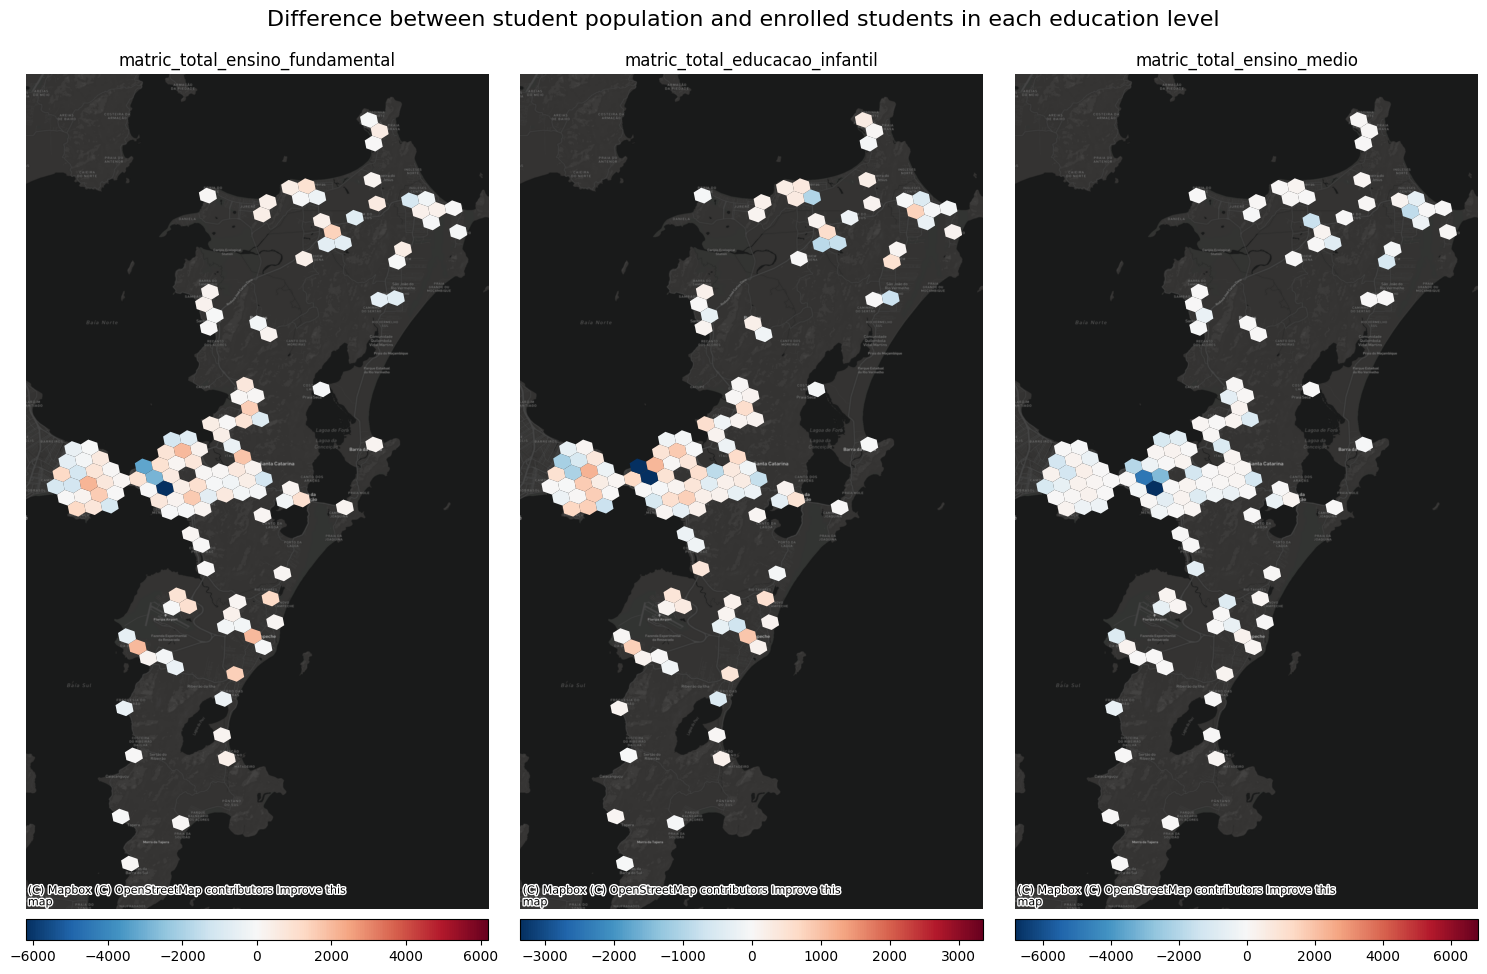

In [181]:
# Plot diff for each education level
fig, axes = plt.subplots(1, 3, figsize=(15, 10))

fig.suptitle(
    "Difference between student population and enrolled students in each education level",
    fontsize=16,
)

for ax, edu_col in zip(axes.flatten(), edu_cols):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="2.5%", pad=0.1)
    ax.set_title(edu_col)
    vmin, vmax = (
        hex_gdf[f"diff_pop_{edu_col}"].min(),
        hex_gdf[f"diff_pop_{edu_col}"].max(),
    )
    vval = max(abs(vmin), abs(vmax))
    hex_gdf.plot(
        f"diff_pop_{edu_col}",
        ax=ax,
        cmap="RdBu_r",
        legend=True,
        cax=cax,
        legend_kwds={"orientation": "horizontal"},
        vmin=-vval,
        vmax=vval,
    )
    ax.set_axis_off()
    cx.add_basemap(ax, crs=hex_gdf.crs.to_string(), source=BASEMAP_DARK)

plt.tight_layout()

This maps shows the difference between the number of students and the target student population for each education level. 

- **Blue hexagons** have negative values and represent areas where there are **more students than the target population**.
- **Red hexagons** have positive values and represent areas where there are **less students than the target population**.

Given this we could say that:

- Blue hexagons are city centers were there is less population but have a lot of students that come from other areas.
- Red hexagons are most present in rural areas were there is more target student population that have to travel to other areas to attend school.
- This second group could be in danger of not attending school due to the distance.

## Step 4. Assing the hexagon zone (rural or urban) 


We will use the census track variable to determine the urban area of Pará.

In [182]:
urban_area = geobr.read_urban_area(year=2015)

In [183]:
flor_urban_area = urban_area.clip(flor_muni.unary_union)

In [184]:
flor_urban_area = flor_urban_area.to_crs(hex_gdf.crs)

In [185]:
flor_urban_area_gdf = gpd.GeoDataFrame(
    geometry=[flor_urban_area.unary_union], crs=flor_urban_area.crs
)

In [186]:
# Generate hexagons using urban area as boundary
flor_urban_area_hex = up.geom.gen_hexagons(resolution=8, city=flor_urban_area_gdf)
flor_urban_area_idx = flor_urban_area_hex["hex"].unique().tolist()

In [187]:
# Create urban_area column in hex
hex_gdf["urban_area"] = 0
# Assign 1 to hexagons that area in the urban area
hex_gdf.loc[hex_gdf["hex"].isin(flor_urban_area_idx), "urban_area"] = 1

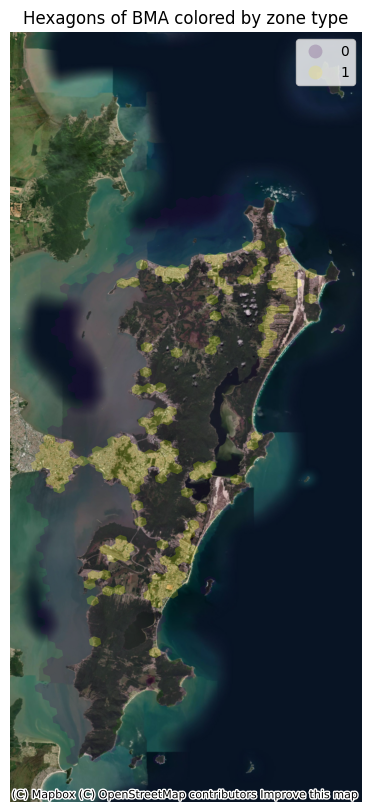

In [188]:
ax = hex_gdf.plot(
    "urban_area",
    legend=True,
    categorical=True,
    alpha=0.2,
    figsize=(10, 10),
    cmap="viridis",
)

# Set title and legend
ax.set_title("Hexagons of BMA colored by zone type")

# Add basemap
cx.add_basemap(ax, crs=flor_muni.crs.to_string(), source=BASEMAP)

# Remove axis
ax.set_axis_off()

plt.savefig(
    f"outputs/maps/{city}/10-{city}_hexagon_urban.png", dpi=300, bbox_inches="tight"
)

plt.show()

We can see that the urban areas are correctly identified. Considering the satellite image, urban areas are the ones with more buildings and roads.

In [191]:
# Finally, we can save the hexagons as a parquet file without the geometry column
hex_gdf.drop("geometry", axis=1).to_parquet(
    f"outputs/31102023_{city}_hexs_final.parquet"
)

## Summary

We have extracted and processed schools and sociodemographic data from multiple source. The final results is a dataset on which each row is a H3 Hexagon. This will allow us to compare and analyze different microregions in Para. The variables obtained are the the following:  

| Source | Variable name | Type | Description |
| --- | --- | --- | --- |
| Meta's HRSM | population_2020 | Numerical | Total Population |
| IBGE's Census* | pop_3_5_years_adj | Numerical | Population between 3 months and 5 years old |
| IBGE's Census* | pop_6_14_years_adj | Numerical | Population between 6 and 14 years old |
| IBGE's Census* | pop_15_17_years_adj | Numerical | Population between 15 and 17 years old |
| IBGE's Census* | pop_18_years_adj | Numerical | Population between 18 years old |
| IBGE's Census* | V002_adj | Numerical | Total Population |
| IBGE's Census* | V003_adj | Numerical | Income (R$) |
| INEP's School Census | ensino_fundamental | Numerical | Ensino Fundamental Schools Count |
| INEP's School Census | educacao_infantil | Numerical | Educacao Infantil Schools Count |
| INEP's School Census | ensino_medio | Numerical | Ensino Medio Schools Count |
| INEP's School Census | educacao_jovens_adultos | Numerical | Educacao Jovens Adultos Schools Count |
| INEP's School Census | educacao_profissional | Numerical | Educacao Profissional Schools Count |
| INEP's School Census | no_specified | Numerical | Count of schools with unspecified type |
| INEP's School Census | publica | Numerical | Public Schools Count |
| INEP's School Census | privada | Numerical | Private Schools Count |
| Custom School Census** | Matriculas totales | Numerical | Total Enrolled Students |
| Custom School Census** | Matrículas oficiales | Numerical | Oficially Enrolled Students |
| Custom School Census** | matric_total_[school type] | Numerical | Enrolled Students by School Type |
| Custom School Census** | matric_oficial_[school type] | Numerical | Enrolled Students by School Type |
| Custom School Census** | diff_pop_matric_total_[school type] | Numerical | Difference between target student population and enrolled students by School Type |
| Custom School Census** | rate_pop_matric_total_[school type] | Numerical | Ratio between target student population and enrolled students by School Type |
| IBGE's Urban Footprints | urban_area | Categorical | 1=Urban or 0=Rural |
| Ours | income_pc | Numerical | Income Per Capita (R$) |  

\* IBGE's Census: Variables where downscaled proportionally to Meta's high resolution population data.  
\*\* Custom School Census: This dataset was provided by IDB Education team in Brazil (need to ask for the source)